In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
plt.rcParams.update({'font.size': 16})

## Fossil-Fuel CO2 Emissions


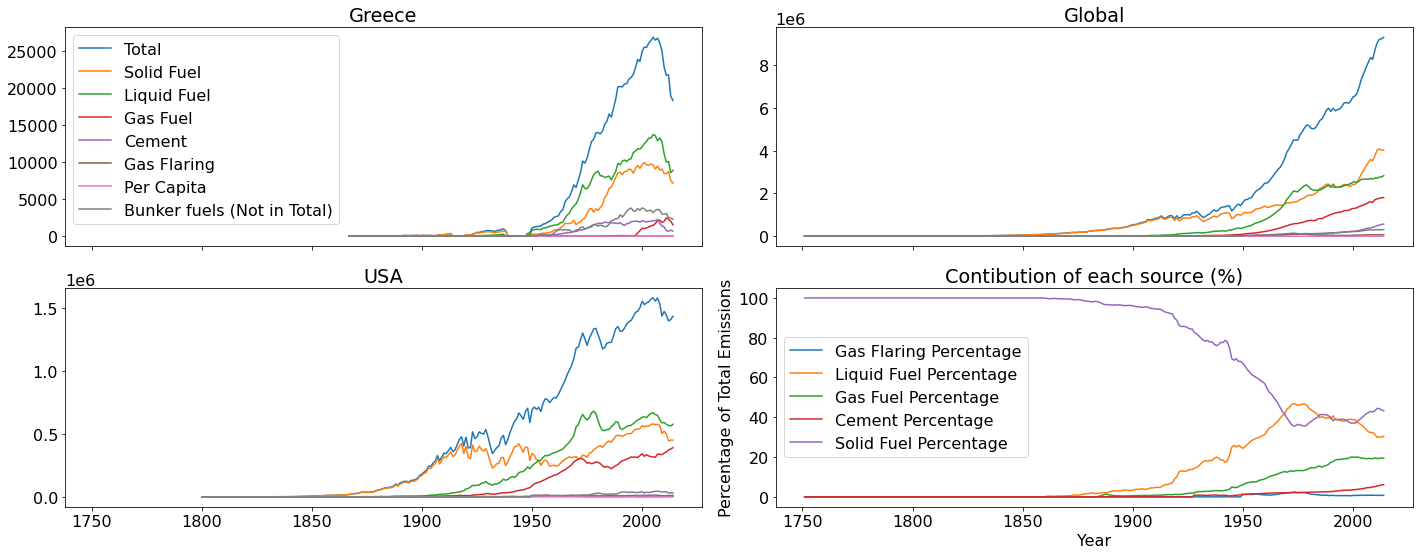

In [2]:
df = pd.read_csv("data/fossil-fuel-co2-emissions-by-nation.csv")

df_global = df.groupby('Year').sum()
# plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.size': 16})

df.index = df.Year

df_gr = df[df.Country=="GREECE"].drop(columns=["Country","Year"])
df_us = df[df.Country=="UNITED STATES OF AMERICA"].drop(columns=["Country","Year"])
fig, axs = plt.subplots(2,2,figsize=(20,8),sharex=True)
axs[0,0].plot(df_gr)
axs[0,0].set_title("Greece")
axs[1,0].plot(df_us)
axs[1,0].set_title("USA")
axs[0,1].plot(df_global)
axs[0,1].set_title("Global")
axs[0,0].legend(df_gr.columns, loc="best")


df_global['Solid Fuel Percentage'] = df_global['Solid Fuel']/df_global['Total'] * 100
df_global['Cement Percentage'] = df_global['Cement']/df_global['Total'] * 100
df_global['Gas Fuel Percentage'] = df_global['Gas Fuel']/df_global['Total'] * 100
df_global['Liquid Fuel Percentage'] = df_global['Liquid Fuel']/df_global['Total'] * 100
df_global['Gas Flaring Percentage'] = df_global['Gas Flaring']/df_global['Total'] * 100

df_global[['Gas Flaring Percentage','Liquid Fuel Percentage','Gas Fuel Percentage','Cement Percentage','Solid Fuel Percentage']].plot(ax=axs[1,1])
plt.ylabel('Percentage of Total Emissions')
axs[1,1].set_title('Contibution of each source (%)')
plt.tight_layout()

## Aggregate by Country

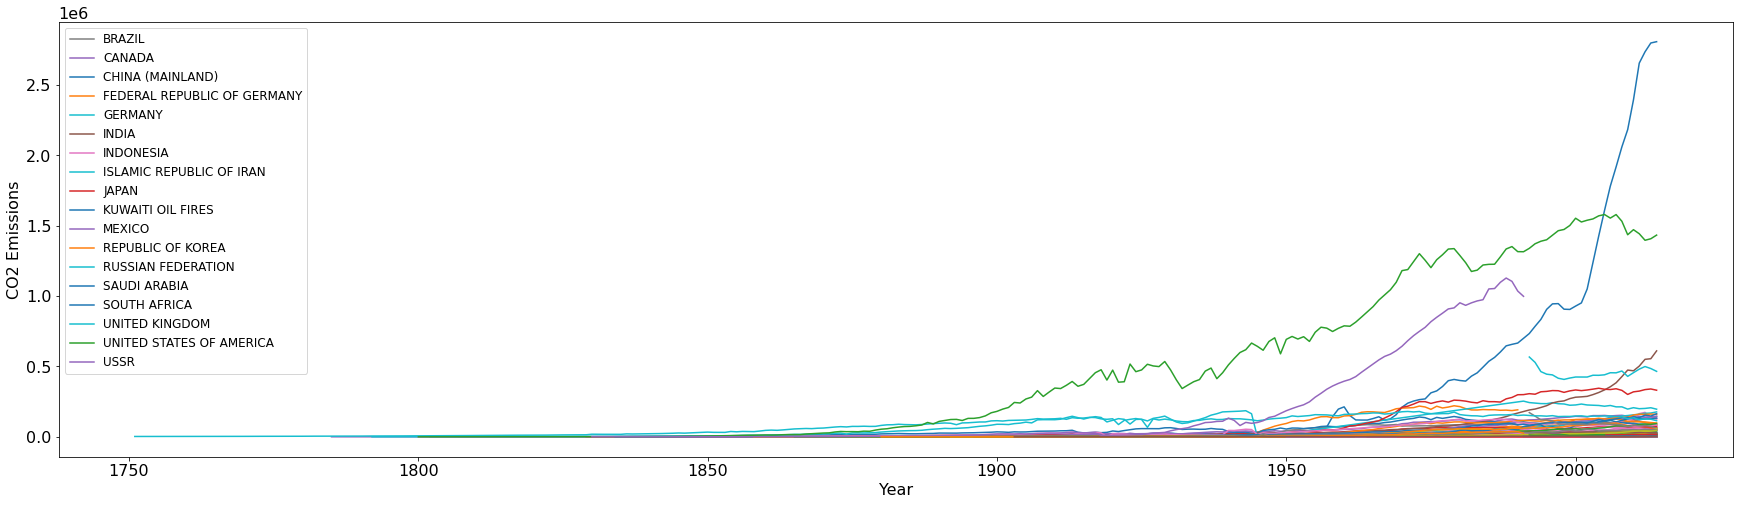

In [3]:
df = pd.read_csv("/home/filby/workspace/exorixi/co2-fossil-by-nation/data/fossil-fuel-co2-emissions-by-nation.csv")
df = df[['Year','Country', 'Total']]
df.index = df.Year
df = df.drop(columns='Year')
fig, ax = plt.subplots(figsize=(30,8))
plt.rcParams.update({'font.size': 12})

for label, df1 in df.groupby('Country'):
    try:
        # include only countries with higher last measurement than 0.1e6
        if float(df1.iloc[-1]['Total']) < 0.1e6:
            label = '_nolegend_'
    except:
        label = '_nolegend_'
    df1.Total.plot(ax=ax, label=label)
plt.legend()
plt.ylabel('CO2 Emissions')

plt.show()

## Global Temperatures Dataset

Text(0.5, 0, 'Year')

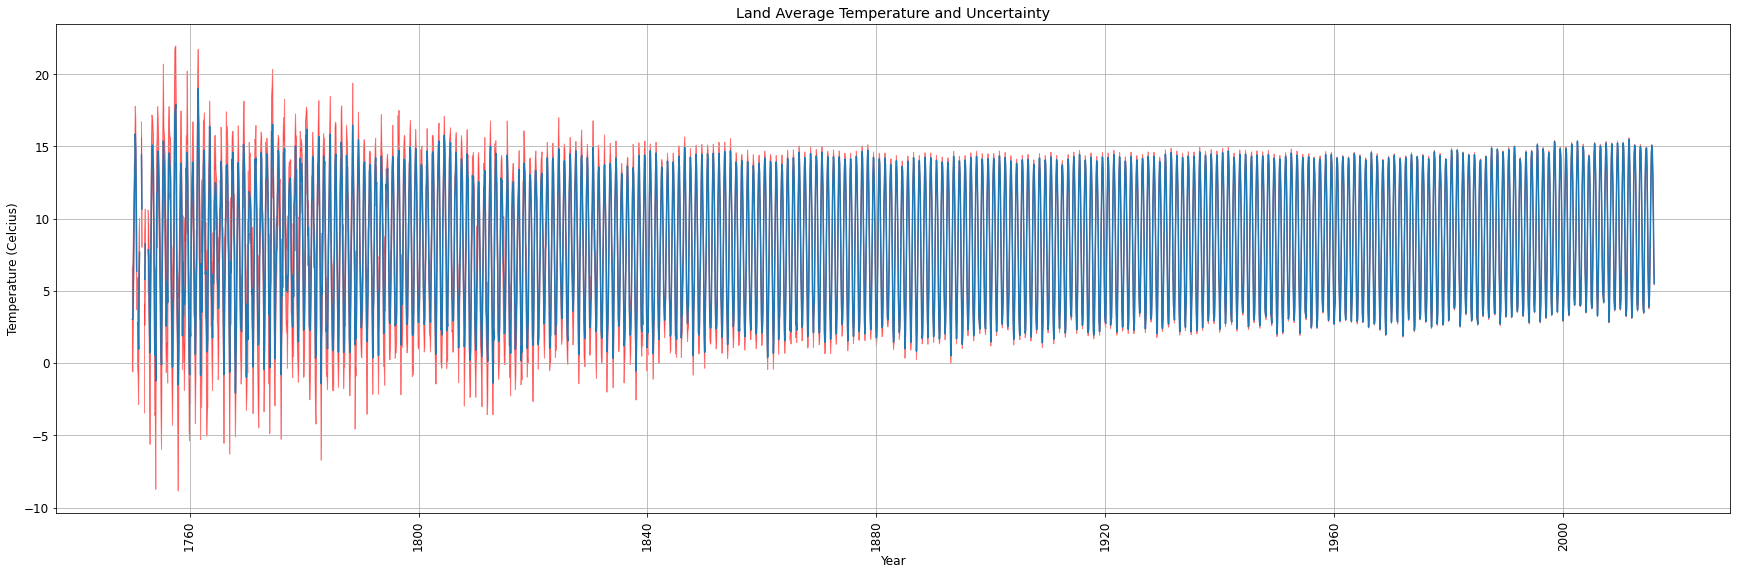

In [4]:
df = pd.read_csv("data/GlobalTemperatures.csv", index_col=0)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots(figsize=(30,9))

ax.plot(df.index,df['LandAverageTemperature'])

ax.fill_between(df.index, df['LandAverageTemperature'] - df['LandAverageTemperatureUncertainty'], df['LandAverageTemperature'] + df['LandAverageTemperatureUncertainty'], color='r', alpha=.5)
ax.grid(True)
f = plt.xticks(rotation = 90)
plt.title('Land Average Temperature and Uncertainty')
plt.ylabel('Temperature (Celcius)')
plt.xlabel('Year')

(-0.8298447266896248, 0.810197850530606, 25, 1605, {'1%': -3.434430865671321, '5%': -2.8633424632707527, '10%': -2.567729595112625}, 938.9167329440656)


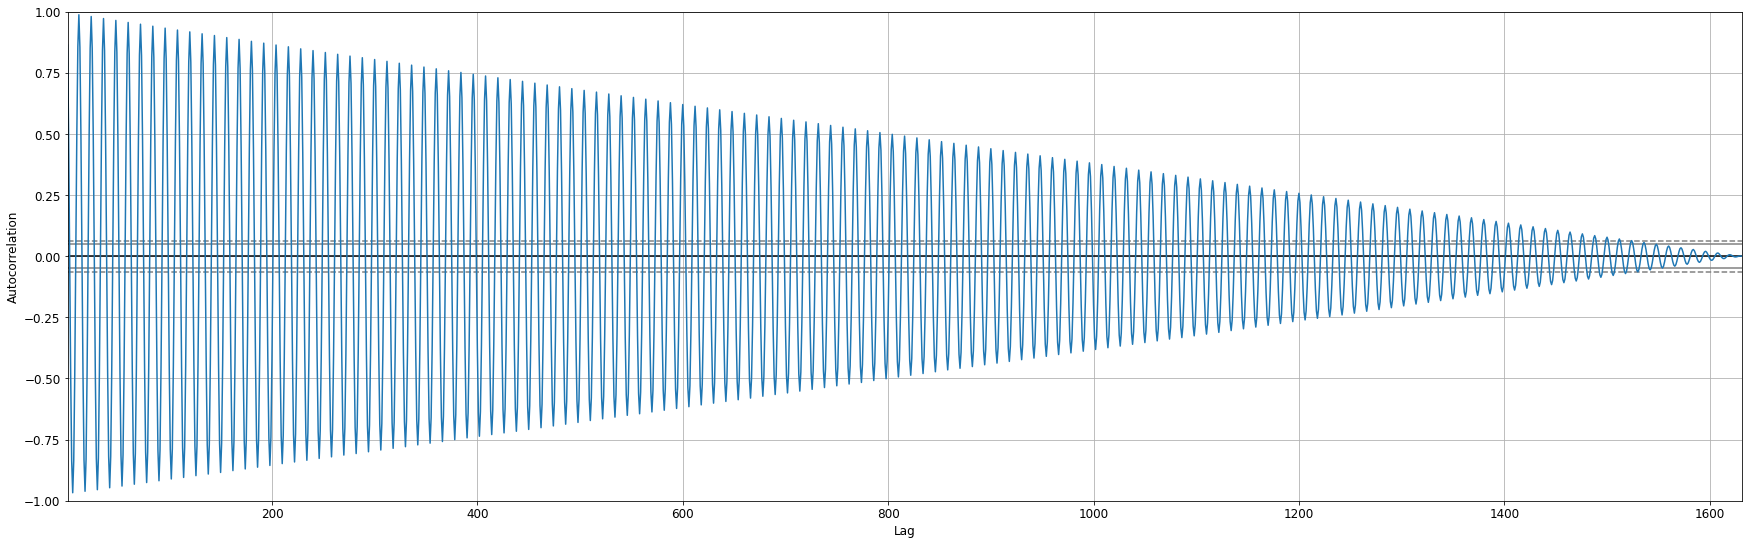

In [5]:
df = df[df.index>datetime.datetime(year=1880,month=1,day=1)]
from fbprophet import Prophet
import seaborn as sns
import numpy as np

df['y'] = df.LandAverageTemperature
df['ds'] = df.index
df.index.freq = df.index.inferred_freq

# check stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.y.values)
adf_stat = result[0]
p_val = result[1]
print(result)


# identify possible components from the autocorrelation plot
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(30,9))
autocorrelation_plot(df.y)
plt.show()


 MeanResidual 0.16512453409032948


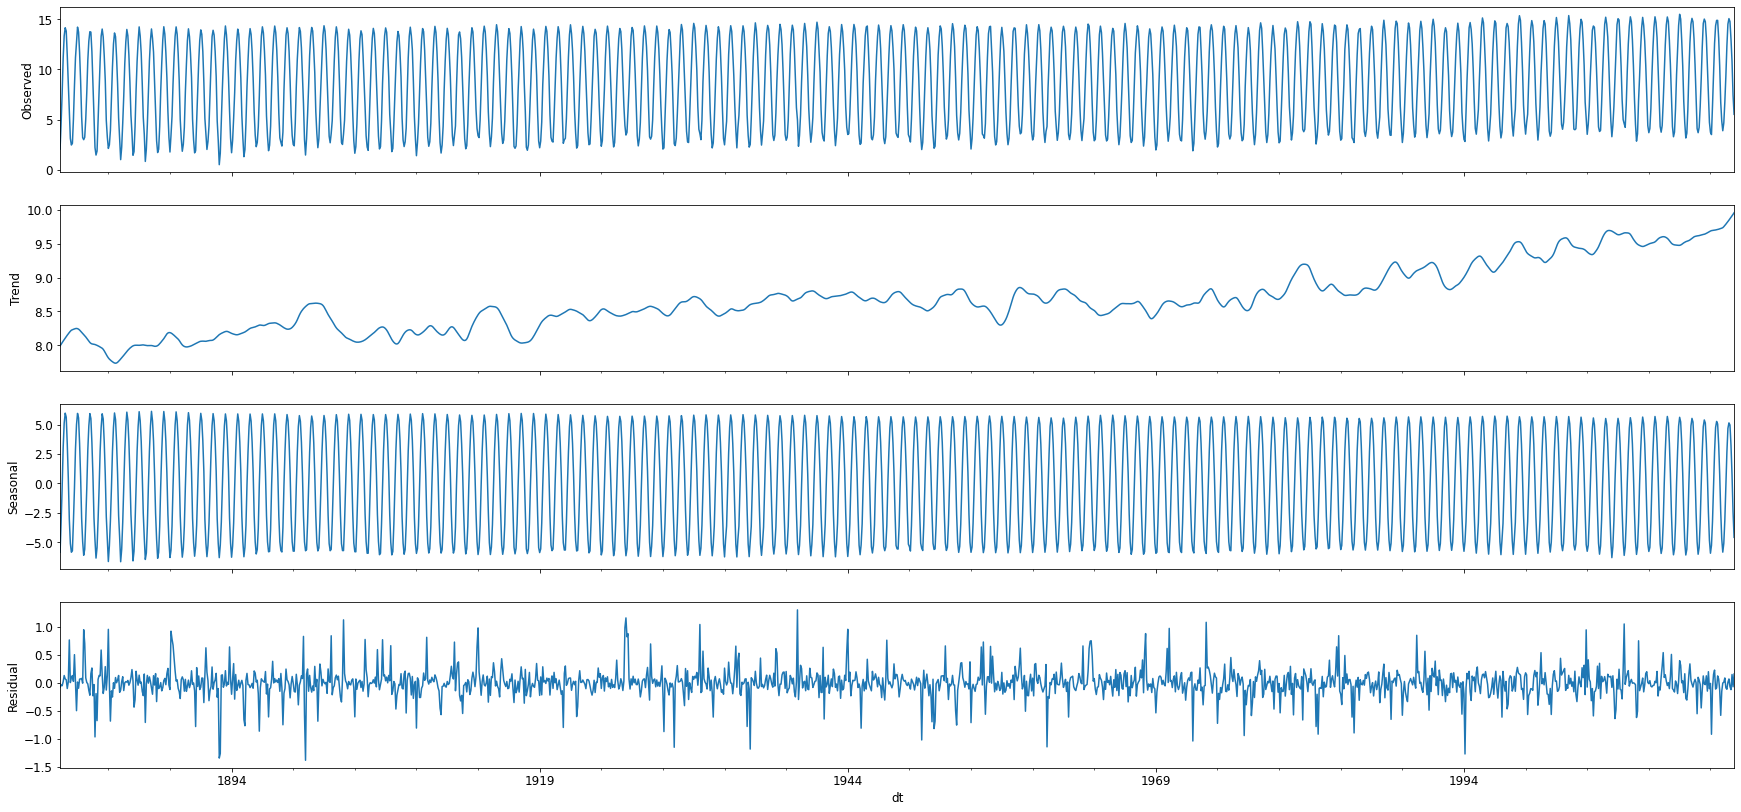

In [6]:
# LOESS 
def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(30,14))

from statsmodels.tsa.seasonal import STL
stl = STL(df['y'], robust=True) # period inferred from freq
res = stl.fit()
plotseasonal(res,axes)
print(' MeanResidual', np.abs(res.resid).mean())

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


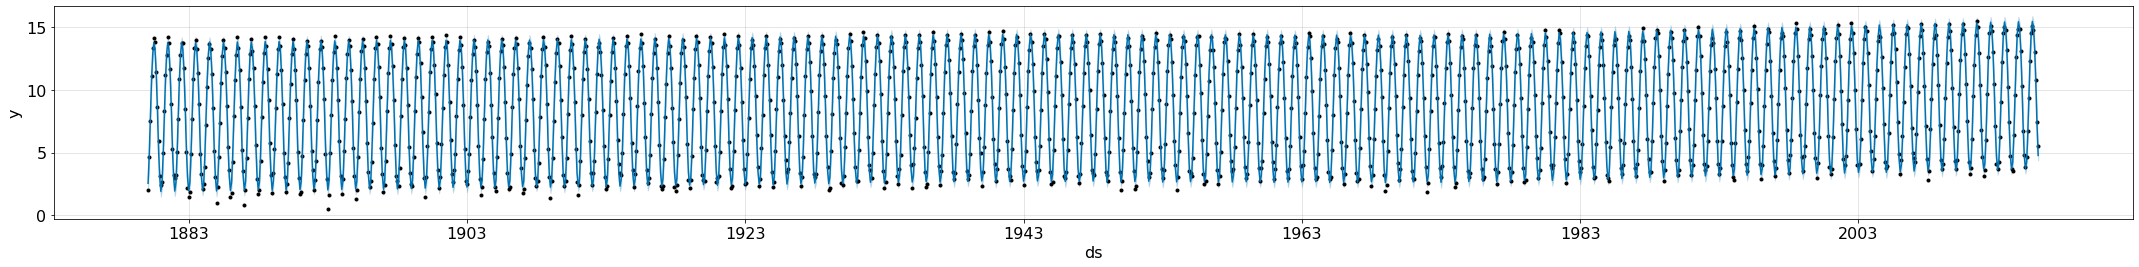

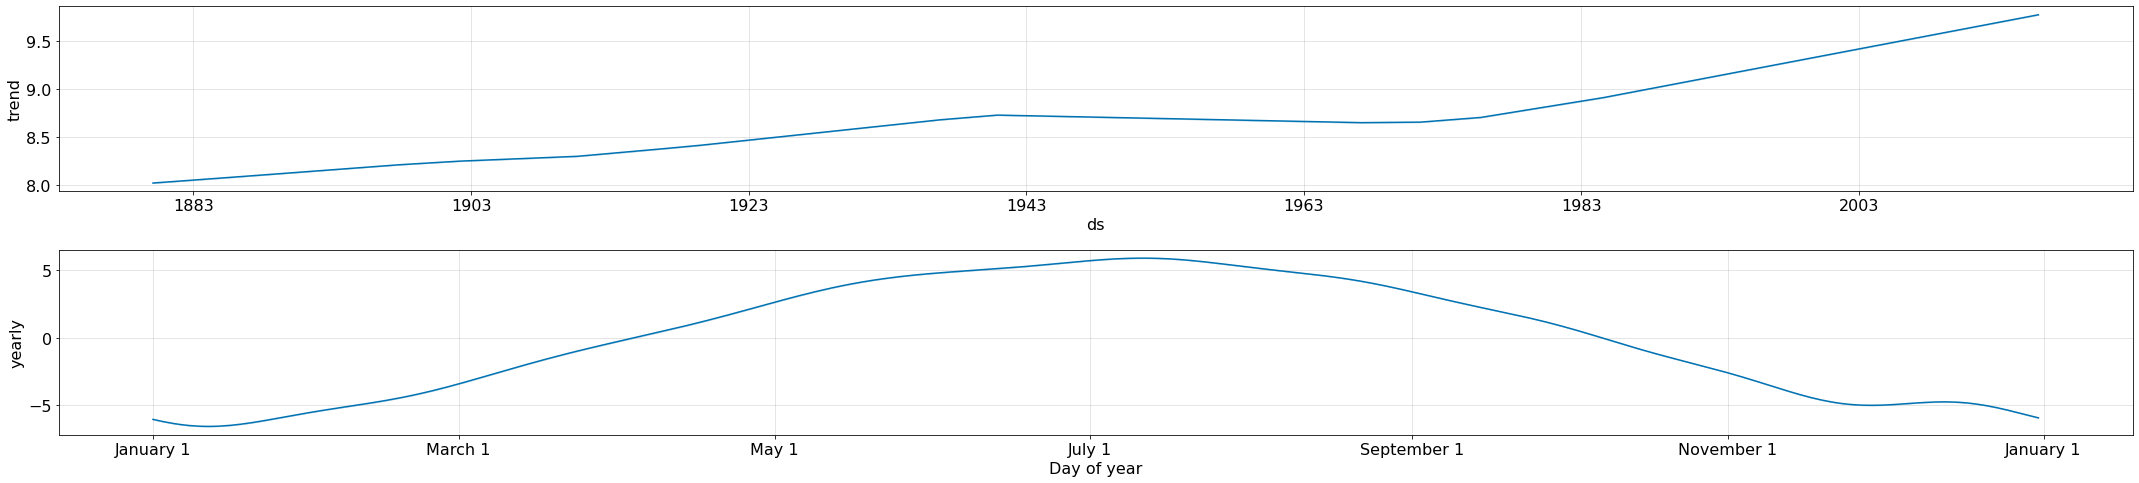

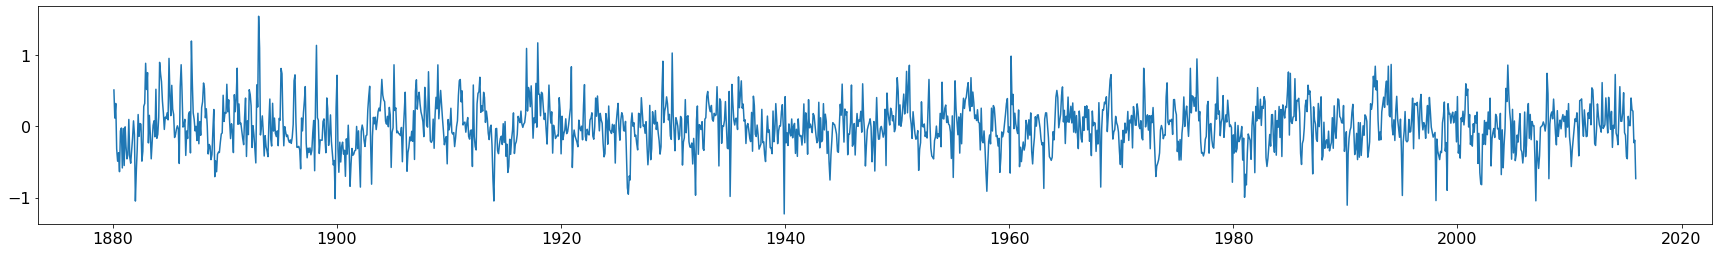

0.2513438424865857


In [9]:
df['y'] = df.LandAverageTemperature
df['ds'] = df.index
plt.rcParams.update({'font.size': 16})

# Python
m = Prophet(seasonality_mode='additive', weekly_seasonality=False)
m.fit(df)



forecast = m.predict(df)

fig1 = m.plot(forecast, figsize=(30,4))

fig2 = m.plot_components(forecast, figsize=(30,7))
plt.show()

forecast.index = pd.to_datetime(forecast.ds)
df['residuals'] = forecast['yhat'] - df['y']
plt.figure(figsize=(30,4))
plt.plot(df.index,df['residuals'])
plt.show()

print(np.mean(np.abs(df['residuals'].values)))


## FORECAST

/gpu-data/filby/miniconda3/envs/stuff/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


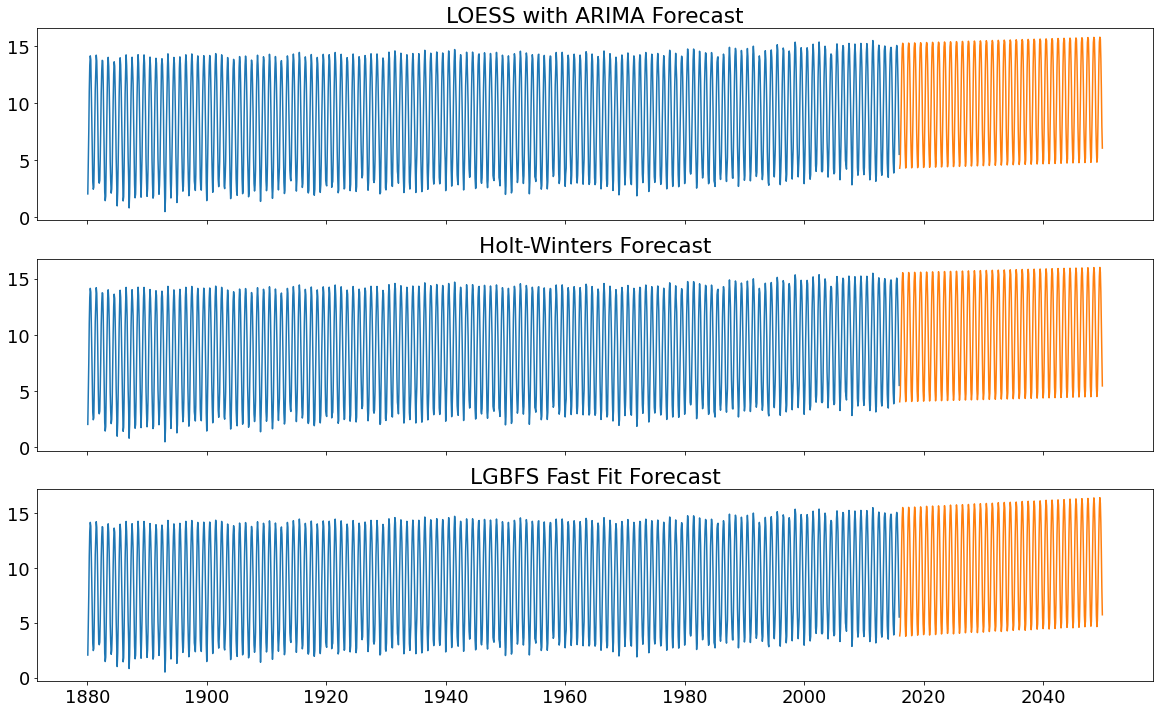

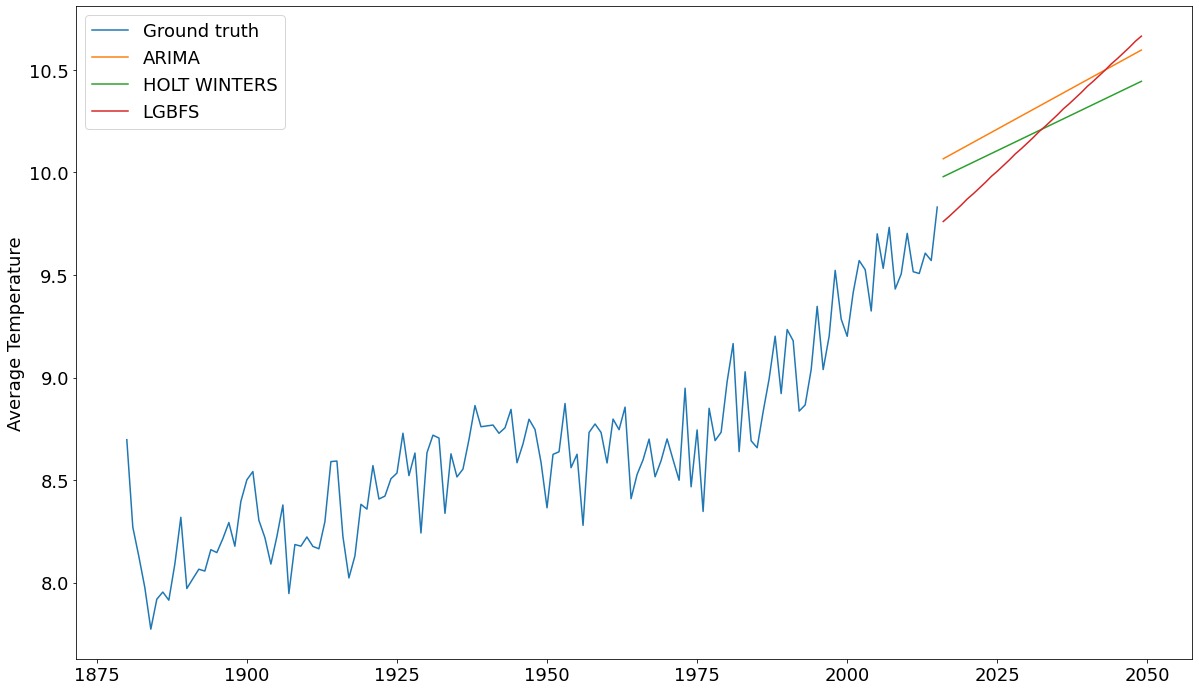

In [11]:
from statsmodels.tsa.forecasting.stl import STLForecast

plt.rcParams.update({'font.size': 18})

fig, axs = plt.subplots(3,1,figsize=(20,12),sharex=True)

# -------------- ARIMA Model -------------- #
from statsmodels.stats.outliers_influence import summary_table

from statsmodels.tsa.arima.model import ARIMA

stlf = STLForecast(df['y'], ARIMA, model_kwargs=dict(order=(1,1,0), trend="t"))
stlf_res = stlf.fit()
forecast_ar = stlf_res.forecast(408)

axs[0].plot(df['y'])
axs[0].plot(forecast_ar)


# -------------- Holt Winters Model -------------- #

from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(df['y'], trend='add', seasonal='add', seasonal_periods=12)

stlf_res = model.fit()

forecast_hw = stlf_res.forecast(408)
# rmse_hw = np.sqrt(np.mean(np.square(df_test['y'].values - forecast_hw[forecast_hw.index.isin(df_test.index)].values)))
rmse_hw = np.abs(stlf_res.resid).mean() # np.sqrt(np.mean(np.square(df_test['y'].values - forecast_ar[forecast_ar.index.isin(df_test.index)].values)))
# print(rmse_hw)

axs[1].plot(df['y'])
axs[1].plot(forecast_hw)

# axs[1,1].plot(df['y'].groupby(df.index.year).mean())
# display(forecast)
# axs[1,1].plot(forecast_hw.groupby(forecast_hw.index.year).mean())


# -------------- Phophet Model -------------- #

m = Prophet(seasonality_mode='additive', weekly_seasonality=False)
m.fit(df)

future = m.make_future_dataframe(periods=408, freq='MS')

forecast = m.predict(future)
forecast = forecast[forecast.ds.isin(forecast_hw.index)]

axs[2].plot(df['y'])
axs[2].plot(forecast.ds,forecast['yhat'])
axs[2].set_title('LGBFS Fast Fit Forecast')
axs[0].set_title('LOESS with ARIMA Forecast')
axs[1].set_title('Holt-Winters Forecast')


plt.figure(figsize=(20,12))
plt.plot(df['y'].groupby(df.index.year).mean())
plt.plot(forecast_ar.groupby(forecast_ar.index.year).mean())
plt.plot(forecast_hw.groupby(forecast_hw.index.year).mean())
plt.plot(forecast['yhat'].groupby(forecast.ds.dt.year).mean())
plt.legend(['Ground truth', 'ARIMA','HOLT WINTERS', 'LGBFS'])
# rmse
# m.plot(forecast)

# axs[2,1].plot(forecast_hw.groupby(forecast_hw.index.year).mean())
# axs[2,1].plot(forecast_ar.groupby(forecast_ar.index.year).mean())
plt.ylabel('Average Temperature')
plt.show()


### Temperature Anomalies

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


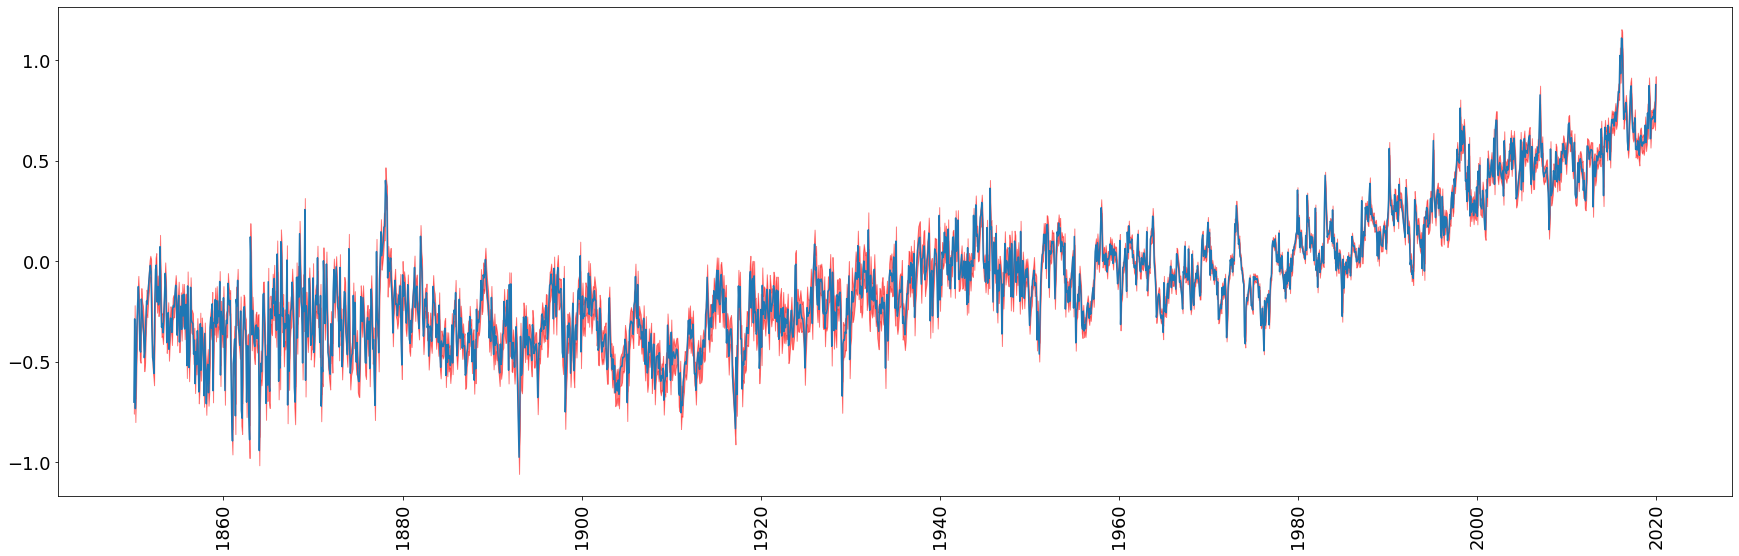

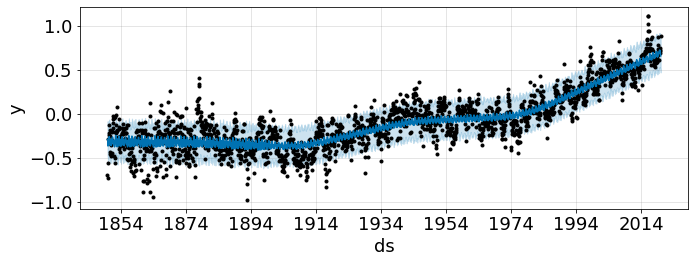

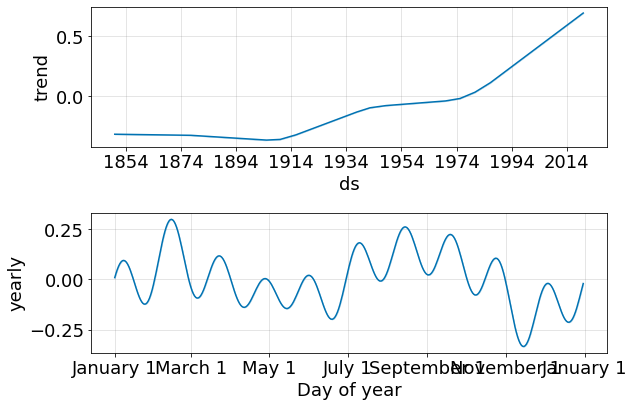

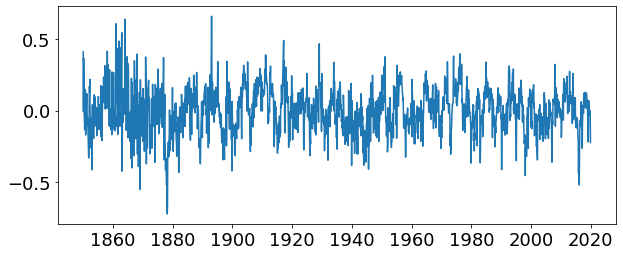

In [12]:
df = pd.read_csv("data/Global Temperature Anomalies.csv")
df.index = pd.to_datetime(df.month_date)

fig, ax = plt.subplots(figsize=(30,9))

ax.plot(df.index,df['anomaly_value'])
# format the ticks

ax.fill_between(df.index, df['lower_95_ci'], df['upper_95_ci'], color='r', alpha=.5)

f = plt.xticks(rotation = 90)


df['y'] = df.anomaly_value
df['ds'] = df.index

# Python
m = Prophet(seasonality_mode='additive', weekly_seasonality=False)
m.fit(df)

forecast = m.predict(df)

fig1 = m.plot(forecast, figsize=(10,4))

fig2 = m.plot_components(forecast)
plt.show()

forecast.index = pd.to_datetime(forecast.ds)
df['residuals'] = forecast['yhat'] - df['y']

plt.figure(figsize=(10,4))
plt.plot(df.index,df['residuals'])
plt.show()

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,1992,0.181697,"[0.14, 0.22]",0.033014,0.032042,3.020619e-16,8.723e+12,1.0


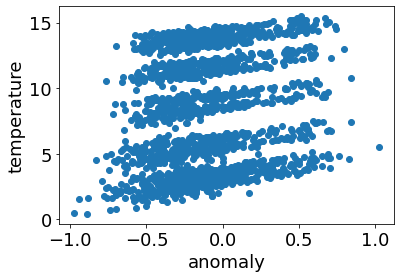

/gpu-data/filby/miniconda3/envs/stuff/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning:

Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.

/gpu-data/filby/miniconda3/envs/stuff/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning:

The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.



In [15]:
df = pd.read_csv("data/Global Temperature Anomalies.csv")
df.index = pd.to_datetime(df.month_date)

df_a = pd.read_csv("data/GlobalTemperatures.csv", index_col=0)
df = df_a.join(df)
# display(df)

plt.scatter(df.anomaly_value,df.LandAverageTemperature)
plt.xlabel('anomaly')
plt.ylabel('temperature')
import pingouin as pg
display(pg.corr(df.anomaly_value,df.LandAverageTemperature,method='pearson'))

\begin{tabular}{lrrlrrrlr}
\toprule
{} &    n &         r &         CI95\% &        r2 &    adj\_r2 &         p-val &       BF10 &  power \\
\midrule
pearson &  264 &  0.697752 &  [0.63, 0.75] &  0.486859 &  0.482926 &  7.727123e-40 &  3.628e+36 &    1.0 \\
\bottomrule
\end{tabular}



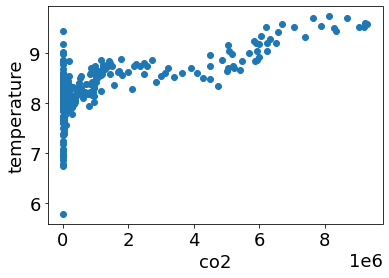

In [16]:
df_a = pd.read_csv("data/GlobalTemperatures.csv", index_col=0)
df_a.index = pd.to_datetime(df_a.index)
df_a = df_a.groupby(df_a.index.year).mean()

df = pd.read_csv("/home/filby/workspace/exorixi/co2-fossil-by-nation/data/fossil-fuel-co2-emissions-by-nation.csv")
df_global = df.groupby('Year').sum()

df = df_a.join(df_global)
plt.scatter(df.Total,df.LandAverageTemperature)
plt.xlabel('co2')
plt.ylabel('temperature')

import pingouin as pg
print(pg.corr(df.Total,df.LandAverageTemperature,method='pearson').to_latex())

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,175,0.096262,"[-0.05, 0.24]",0.009266,-0.002254,0.205068,0.21,0.245484


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,175,0.160021,"[0.01, 0.3]",0.025607,0.014277,0.034399,0.87,0.564423


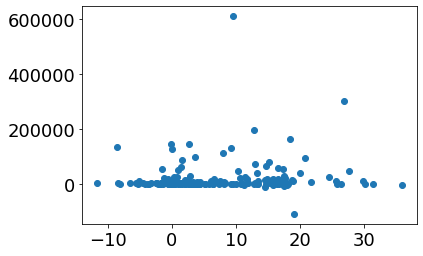

In [17]:
dfav = pd.read_csv("data/GlobalLandTemperaturesByCountry.csv", index_col=0)
# display(df)

df = pd.read_csv("data/fossil-fuel-co2-emissions-by-nation.csv")
df = df[['Year','Country', 'Total']]
df.index = df.Year
df = df.drop(columns='Year')

n = []
ww = []
sus = []
for label, df1 in df.groupby('Country'):
    co2 = float(df1.iloc[-1]['Total']) - float(df1.iloc[0]['Total'])
    
    temp = dfav[dfav.Country.str.lower() == label.lower()].dropna()
    #     print(co2.iloc[-1])
#     display(co2)
    if len(temp) == 0:
        continue
    w = temp.iloc[-1]['AverageTemperature'] - temp.iloc[0]['AverageTemperature']
    
    n.append(w)
    ww.append(co2)
    sus.append(df1.sum()['Total'])

plt.scatter(n,ww)
display(pg.corr(n,ww))
display(pg.corr(n,sus))